# Notebook and Plots for GLM Blog in Scikit-Learn Foundation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF

# import datasets
from plotnine.data import diamonds

# scikit-learn
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.linear_model import GammaRegressor, Ridge
from sklearn.metrics import mean_squared_error, mean_gamma_deviance
from sklearn.model_selection import GroupShuffleSplit
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler

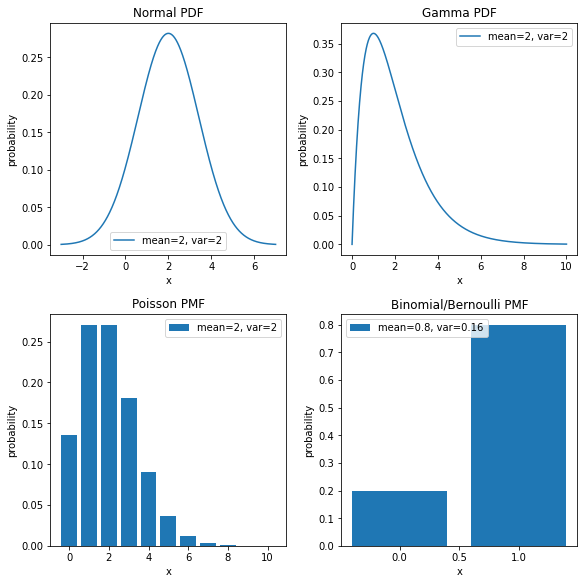

In [2]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8, 8), constrained_layout=True)

mean, var = 2, 2
x = np.linspace(mean-5, mean+5, num=1000)
axes[0, 0].plot(x, stats.norm(loc=mean, scale=np.sqrt(var)).pdf(x),
                label=f"mean={mean}, var={var}")
axes[0, 0].set_title("Normal PDF")

mean, var = 2, 2
x = np.linspace(0, 10, num=1000)
axes[0, 1].plot(x, stats.gamma(a=mean**2/var, scale=var/mean).pdf(x),
                label=f"mean={mean}, var={var}")
axes[0, 1].set_title("Gamma PDF")

mean = 2
var = mean
x = np.arange(0, 11)
axes[1, 0].bar(x, stats.poisson(mu=mean).pmf(x),
               label=f"mean={mean}, var={var}")
axes[1, 0].set_title("Poisson PMF")

mean = 0.8
var = mean * (1 - mean)
x = np.arange(0, 2)
axes[1, 1].bar(x, stats.bernoulli(p=mean).pmf(x),
               label=f"mean={mean}, var={var:.2f}")
axes[1, 1].set_title("Binomial/Bernoulli PMF")

for ax in axes.flat:
    ax.set(xlabel='x', ylabel='probability')
    ax.legend()
axes[1, 1].legend(loc="upper left")
    
# fig.suptitle("Different Probability Distributions")

## 1. Real Worl Data Is Not Normal

Text(0.5, 1.0, 'QQ Plot of diamonds price')

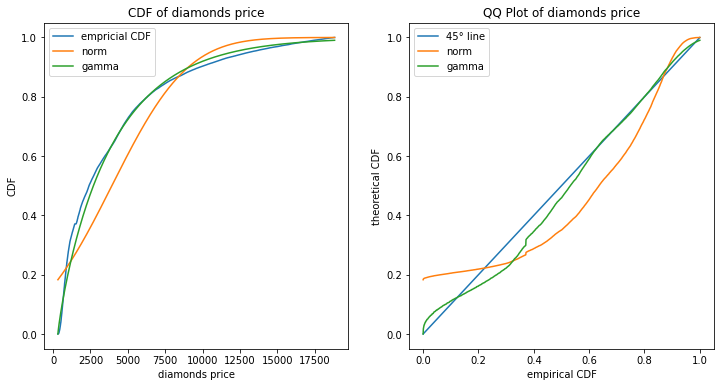

In [3]:
# https://stackoverflow.com/a/37616966 used as template
fig, axes = plt.subplots(1, 2, figsize=(6*2, 6))

y = np.sort(diamonds['price'])
ecdf = ECDF(y)
axes[0].plot(y, ecdf(y), label='empricial CDF')
axes[1].plot(ecdf(y), ecdf(y), label='45° line')

DISTRIBUTIONS = [stats.norm, stats.gamma]

for dist in DISTRIBUTIONS:
    params = dist.fit(y)
    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]
    
    # Plot CDF
    axes[0].plot(y, dist.cdf(y, loc=loc, scale=scale, *arg), label=dist.name)
    # QQ-Plot but with exchanged x- and y-axis such that x-axis stays stable
    axes[1].plot(ecdf(y), dist.cdf(y, loc=loc, scale=scale, *arg), label=dist.name)

axes[0].legend()
axes[0].set_xlabel('diamonds price')
axes[0].set_ylabel('CDF')
axes[0].set_title('CDF of diamonds price')

axes[1].legend()
axes[1].set_xlabel('empirical CDF')
axes[1].set_ylabel('theoretical CDF')
axes[1].set_title('QQ Plot of diamonds price')

## 2. OLS
Already advanced: Fit $log(y) = log(price)$ with feature $log(carat)$.

In [4]:
# Prepare Train Test Split:
# Note that rows of diamonds are highly correlated.
# This happens when cut, color and clarity, carat and price are the same.
print(f"Number of rows = {len(diamonds)}")

df_unique = diamonds.drop_duplicates(subset=["carat", "cut", "color", "clarity", "price"]).copy()
print(f"Number of unique rows = {len(df_unique)}")

# Define group to use as unique group id
df_unique["group"] = np.arange(len(df_unique))

diamonds = pd.merge(diamonds,
                    df_unique.loc[:, ["group", "carat", "cut", "color", "clarity", "price"]],
                    how="left",
                    on=["carat", "cut", "color", "clarity", "price"])

Number of rows = 53940
Number of unique rows = 39756


In [5]:
# Usually:
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)
# But using indices is simpler to keep df together

idx_train, idx_test = list(GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=123)
                           .split(diamonds, groups=diamonds["group"]))[0]
idx_train.shape, idx_test.shape

df = diamonds.copy()
df['set'] = 'train'
df.loc[idx_test, 'set'] = 'test'

In [6]:
log_scale_transformer = make_pipeline(
    FunctionTransformer(np.log, validate=False),
    StandardScaler()
)

ols_preprocessor = ColumnTransformer(
    [("log_carat", log_scale_transformer,
            ["carat"]),
     ("onehot_categorical", OneHotEncoder(),
            ["cut", "color", "clarity"]),
    ]
)

In [7]:
ols =  Pipeline([
    ("preprocessor", ols_preprocessor),
    ("regressor",
     TransformedTargetRegressor(regressor=Ridge(alpha=1e-10),
                                func=np.log, inverse_func=np.exp)),
]).fit(df.loc[idx_train], df.loc[idx_train, 'price'])

In [8]:
print("R^2 on train: ",
      ols.score(df.loc[idx_train], df.loc[idx_train, 'price'])
     )

R^2 on train:  0.9592937650187654


In [9]:
dfp = df.copy()
dfp["observed"] = dfp["price"]
dfp["predicted"] = ols.predict(df)

dfp = dfp.melt(id_vars=["carat", "cut", "color", "clarity", "set"],
               value_vars=["observed", "predicted"])
dfp

,carat,cut,color,clarity,set,variable,value
0,0.23,Ideal,E,SI2,train,observed,326.000000
1,0.21,Premium,E,SI1,test,observed,326.000000
2,0.23,Good,E,VS1,train,observed,327.000000
3,0.29,Premium,I,VS2,train,observed,334.000000
4,0.31,Good,J,SI2,train,observed,335.000000
...,...,...,...,...,...,...,...
107875,0.72,Ideal,D,SI1,train,predicted,2951.547256
107876,0.72,Good,D,SI1,train,predicted,2733.543068
107877,0.70,Very Good,D,SI1,train,predicted,2677.898290
107878,0.86,Premium,H,SI2,train,predicted,2668.206217


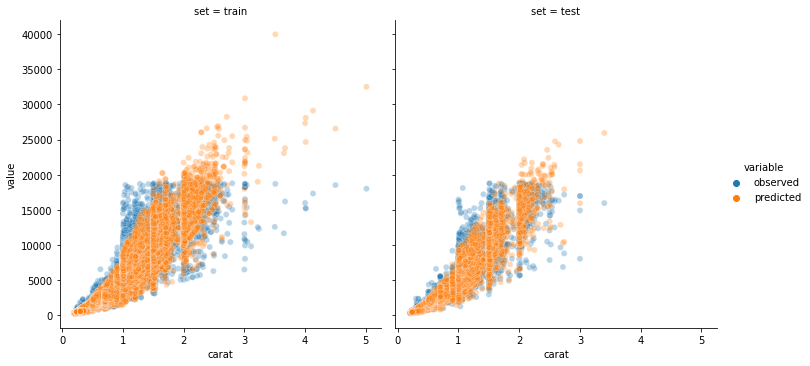

In [10]:
sns.relplot(data=dfp, x='carat', y='value', hue='variable', col='set', alpha=0.3)

Note: As $R^2$ is close to one, most of the variance in $Y$ can be explained by the features leading to the above plot where predicted values cover the observed values very good.

As the prediction is an estimation of $E[Y|X]$, it is maybe better to plot the empirical mean per feature value. This is easier for categorical data (`kind='bar'` instead of `kind='box'`).

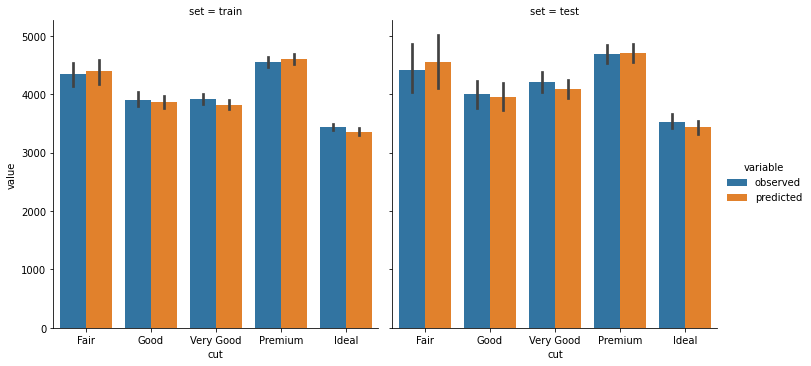

In [11]:
sns.catplot(data=dfp, x='cut', y='value', hue='variable', col='set', kind='bar')

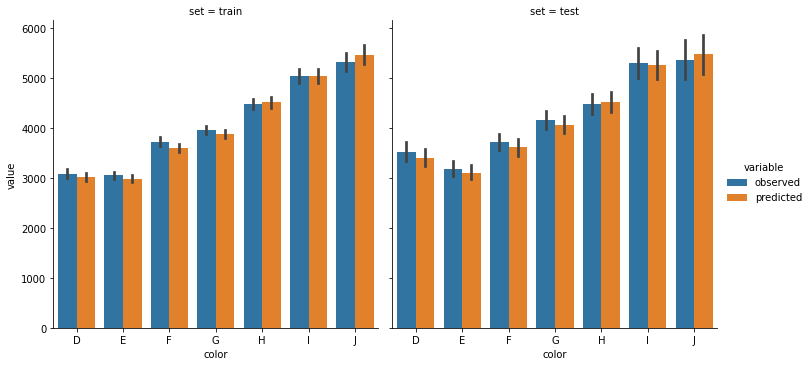

In [12]:
sns.catplot(data=dfp, x='color', y='value', hue='variable', col='set', kind='bar')

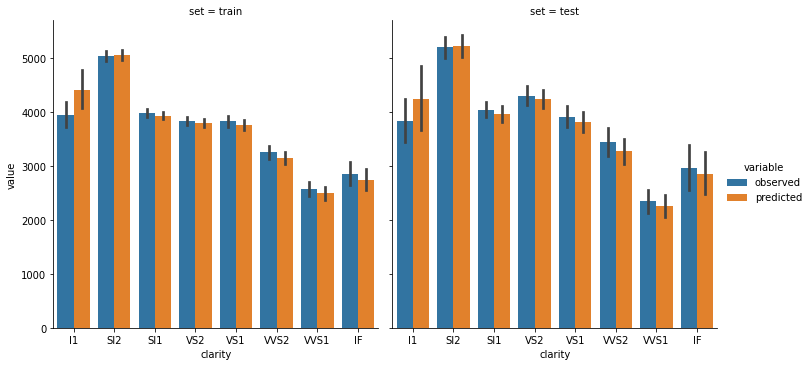

In [13]:
sns.catplot(data=dfp, x='clarity', y='value', hue='variable', col='set', kind='bar')

## 3. GLM

In [14]:
glm =  Pipeline([
    ("preprocessor", ols_preprocessor),
    ("regressor",
     GammaRegressor(alpha=1e-10)),
]).fit(df.loc[idx_train], df.loc[idx_train, 'price'])

In [15]:
dfp = df.copy()
dfp['observed'] = dfp['price']
dfp['predicted'] = ols.predict(df)

dfp = dfp.melt(id_vars=['carat', 'cut', 'color', 'clarity', 'set'], value_vars=['observed', 'predicted'])

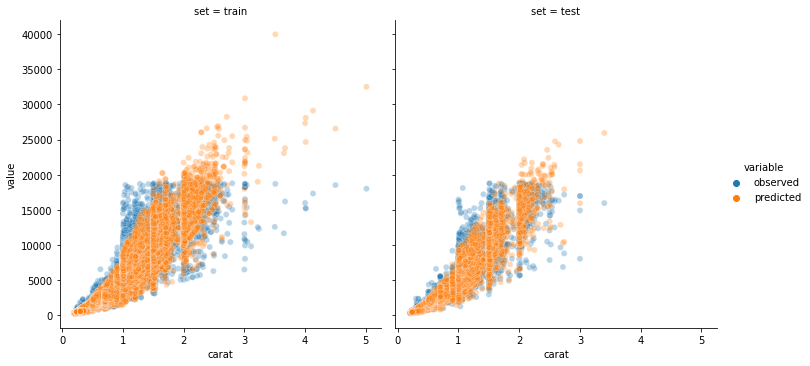

In [16]:
sns.relplot(data=dfp, x='carat', y='value', hue='variable', col='set', alpha=0.3)

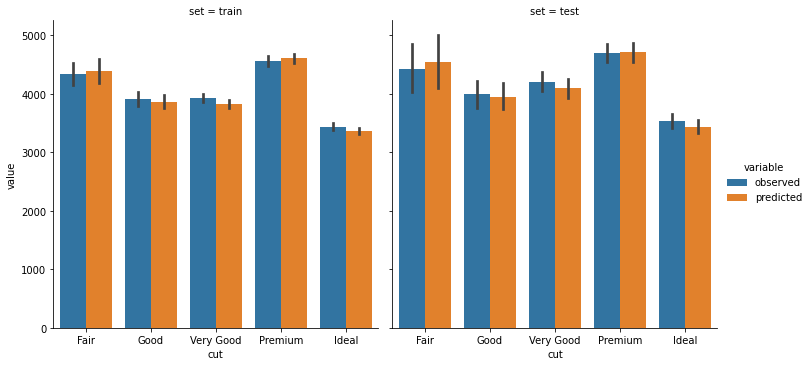

In [17]:
sns.catplot(data=dfp, x='cut', y='value', hue='variable', col='set', kind='bar')

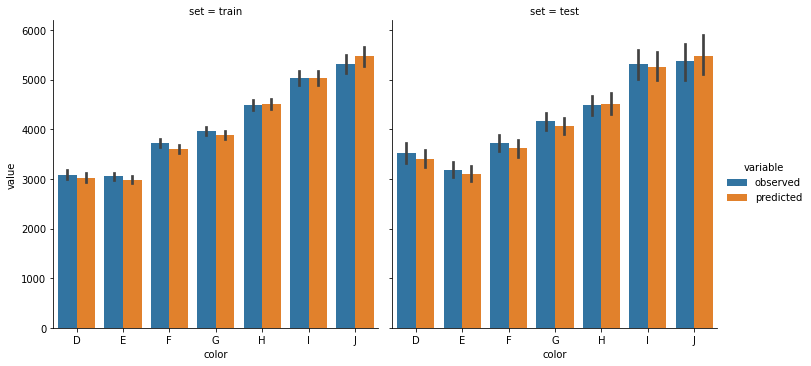

In [18]:
sns.catplot(data=dfp, x='color', y='value', hue='variable', col='set', kind='bar')

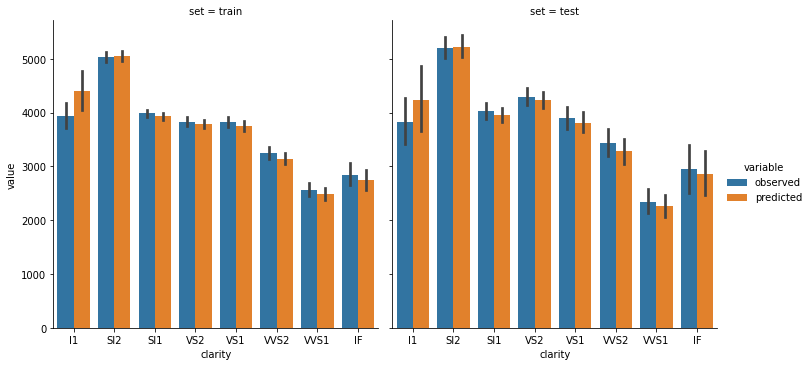

In [19]:
sns.catplot(data=dfp, x='clarity', y='value', hue='variable', col='set', kind='bar')

## 4. Compare Models
### 4.1 RMSE

In [20]:
df['price'].mean()

3932.799721913237

In [21]:
print("OLS RMSE train = ",
      mean_squared_error(df.loc[idx_train, 'price'], ols.predict(df.loc[idx_train]), squared=False))
print("OLS RMSE test = ",
      mean_squared_error(df.loc[idx_test, 'price'], ols.predict(df.loc[idx_test]), squared=False))

OLS RMSE train =  801.5328111590738
OLS RMSE test =  804.7789612056414


In [22]:
print("GLM RMSE train = ",
      mean_squared_error(df.loc[idx_train, 'price'], glm.predict(df.loc[idx_train]), squared=False))
print("GLM RMSE test = ",
      mean_squared_error(df.loc[idx_test, 'price'], glm.predict(df.loc[idx_test]), squared=False))

GLM RMSE train =  804.861664172375
GLM RMSE test =  806.0280620849536


### 4.2 Gamma Deviance

In [23]:
print("OLS Gamma Deviance train = ",
      mean_gamma_deviance(df.loc[idx_train, 'price'], ols.predict(df.loc[idx_train])))
print("OLS Gamma Deviance test = ",
      mean_gamma_deviance(df.loc[idx_test, 'price'], ols.predict(df.loc[idx_test])))

OLS Gamma Deviance train =  0.01823845312212011
OLS Gamma Deviance test =  0.018259680096631325


In [24]:
print("GLM Gamma Deviance train = ",
      mean_gamma_deviance(df.loc[idx_train, 'price'], glm.predict(df.loc[idx_train])))
print("GLM Gamma Deviance test = ",
      mean_gamma_deviance(df.loc[idx_test, 'price'], glm.predict(df.loc[idx_test])))

GLM Gamma Deviance train =  0.018140618492889424
GLM Gamma Deviance test =  0.018171870719364942


Each models is better in the evaluation metric that is uses for fit. No suprise here.

### 4.2 Balance Property / Bias - Calibration
Ideally, on training set, one has $\sum predicted = \sum observed$. Both estimators do not fullfil this requirement. The OLS because of the backtransformation from $\log(y)$ to $y$, the GLM because the $log$ link is not the canonical link.

In [25]:
print("OLS on training set: sum predicted - sum observed = "
      f"{ols.predict(df.loc[idx_train]).sum() - df.loc[idx_train, 'price'].sum():.2g}")
print("GLM on training set: sum predicted - sum observed = "
      f"{glm.predict(df.loc[idx_train]).sum() - df.loc[idx_train, 'price'].sum():.2g}")

OLS on training set: sum predicted - sum observed = -1.9e+06
GLM on training set: sum predicted - sum observed = -6e+05


In [26]:
print("OLS on test set: sum predicted - sum observed = "
       f"{ols.predict(df.loc[idx_test]).sum() - df.loc[idx_test, 'price'].sum():.2g}")
print("GLM on test set: sum predicted - sum observed = "
       f"{glm.predict(df.loc[idx_test]).sum() - df.loc[idx_test, 'price'].sum():.2g}")

OLS on test set: sum predicted - sum observed = -6.2e+05
GLM on test set: sum predicted - sum observed = -2.8e+05


This bias can easily be corrected for. As both models have a multiplicative structure, we can simpliy multiply by one constant learned from the training set: We **calibrate** our models.

In [27]:
ols_bias_corr = df.loc[idx_train, 'price'].sum() / ols.predict(df.loc[idx_train]).sum()
glm_bias_corr = df.loc[idx_train, 'price'].sum() / glm.predict(df.loc[idx_train]).sum()

In [28]:
print("Bias corrected OLS on training set: sum predicted - sum observed = "
      f"{ols_bias_corr * ols.predict(df.loc[idx_train]).sum() - df.loc[idx_train, 'price'].sum():.2g}")
print("Bias corrected GLM on training set: sum predicted - sum observed = "
      f"{glm_bias_corr * glm.predict(df.loc[idx_train]).sum() - df.loc[idx_train, 'price'].sum():.2g}")

Bias corrected OLS on training set: sum predicted - sum observed = -3e-08
Bias corrected GLM on training set: sum predicted - sum observed = 3e-08


In [29]:
print("Bias corrected OLS on test set: sum predicted - sum observed = "
      f"{ols_bias_corr * ols.predict(df.loc[idx_test]).sum() - df.loc[idx_test, 'price'].sum():.2g}")
print("Bias corrected GLM on test set: sum predicted - sum observed = "
      f"{glm_bias_corr * glm.predict(df.loc[idx_test]).sum() - df.loc[idx_test, 'price'].sum():.2g}")

Bias corrected OLS on test set: sum predicted - sum observed = -1.3e+05
Bias corrected GLM on test set: sum predicted - sum observed = -1.3e+05


Let's also have a look at the impact on the test scores:

In [30]:
print("Bias corrected OLS RMSE test = "
      f"{mean_squared_error(df.loc[idx_test, 'price'], ols_bias_corr * ols.predict(df.loc[idx_test]), squared=False)}")
print("Bias corrected GLM RMSE test = "
      f"{mean_squared_error(df.loc[idx_test, 'price'], glm_bias_corr * glm.predict(df.loc[idx_test]), squared=False)}")

Bias corrected OLS RMSE test = 803.2366372654126
Bias corrected GLM RMSE test = 806.0378085161229


In [31]:
print("Bias corrected OLS Gamma Deviance test = "
      f"{mean_gamma_deviance(df.loc[idx_test, 'price'], ols_bias_corr * ols.predict(df.loc[idx_test]))}")
print("Bias corrected GLM Gamma Deviance test = "
      f"{mean_gamma_deviance(df.loc[idx_test, 'price'], glm_bias_corr * glm.predict(df.loc[idx_test]))}")

Bias corrected OLS Gamma Deviance test = 0.018164920159459558
Bias corrected GLM Gamma Deviance test = 0.01817811983616663


This may come as a surprise: While the GLM test scores stay more or less the same, the OLS improves for both RMSE and Gamma deviance. The calibrated OLS has the best test scores, in both metrics!